In [19]:
import pandas as pd
from datetime import datetime

# Define the column names as provided
column_names = ['date', 'time', 'epoch', 'moteid', 'temperature', 'humidity', 'light', 'voltage']

# Load the data with proper column names
df = pd.read_csv('data/data.txt', sep=' ', header=None, names=column_names)

# Function to parse the time with fallback for different formats
def parse_time(time_str):
    try:
        return datetime.strptime(time_str, '%H:%M:%S.%f').time()
    except ValueError:
        try:
            return datetime.strptime(time_str, '%H:%M:%S').time()
        except ValueError:
            return None

# Apply the function to the 'time' column
df['time'] = df['time'].apply(parse_time)

# Ensure the 'date' column is parsed correctly
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce').dt.date

# Ensure correct data types for other columns
df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce').astype('Int64')
df['moteid'] = pd.to_numeric(df['moteid'], errors='coerce').astype('Int64')
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
df['light'] = pd.to_numeric(df['light'], errors='coerce')
df['voltage'] = pd.to_numeric(df['voltage'], errors='coerce')

# Print the last few rows of the dataframe to verify
print(df.tail())

# Optionally, handle any rows where the date or time could not be parsed
invalid_dates = df[df['date'].isna()]
invalid_times = df[df['time'].isna()]

print("Rows with invalid dates:")
print(invalid_dates)

print("Rows with invalid times:")
print(invalid_times)


               date             time  epoch  moteid  temperature  humidity  \
2313677  2004-04-02  01:14:54.164318  61274    <NA>          NaN       NaN   
2313678  2004-04-02  01:17:53.670524  61275    <NA>          NaN       NaN   
2313679  2004-04-02  01:20:52.807972  61276    <NA>          NaN       NaN   
2313680  2004-04-02  01:26:53.950342  61278    <NA>          NaN       NaN   
2313681  2004-04-02  01:35:53.897412  61280    <NA>          NaN       NaN   

         light  voltage  
2313677    NaN      NaN  
2313678    NaN      NaN  
2313679    NaN      NaN  
2313680    NaN      NaN  
2313681    NaN      NaN  
Rows with invalid dates:
Empty DataFrame
Columns: [date, time, epoch, moteid, temperature, humidity, light, voltage]
Index: []
Rows with invalid times:
Empty DataFrame
Columns: [date, time, epoch, moteid, temperature, humidity, light, voltage]
Index: []


In [20]:
df = df.dropna()

# Print the last few rows of the dataframe to verify
len(df)

2219803

In [21]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Parse the 'time' column dynamically
df['time'] = pd.to_datetime(df['time'], errors='coerce', format='%H:%M:%S.%f').dt.time
df['time'] = df['time'].fillna(pd.to_datetime(df['time'], errors='coerce', format='%H:%M:%S').dt.time)

In [22]:
# Remove rows where 'time' could not be parsed (NaT values)
df = df.dropna(subset=['time'])

In [23]:
# Combine 'date' and 'time' into a single 'datetime' column
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

In [24]:
df = df[df['temperature'] <= 50]

In [25]:
df.describe()

,date,epoch,moteid,temperature,humidity,light,voltage,datetime
count,1828664,1828664.0,1828664.0,1.828664e+06,1.828664e+06,1.828664e+06,1.828664e+06,1828664
mean,2004-03-09 17:13:32.532866176,30210.487565,28.898613,2.218359e+01,3.928624e+01,4.096990e+02,2.554382e+00,2004-03-10 05:17:08.475608064
min,2004-02-28 00:00:00,0.0,1.0,-3.840000e+01,-8.983130e+03,0.000000e+00,1.803690e-02,2004-02-28 00:58:46.002832
25%,2004-03-04 00:00:00,14388.0,17.0,2.000800e+01,3.540340e+01,3.956000e+01,2.474670e+00,2004-03-04 05:23:32.657590656
50%,2004-03-09 00:00:00,28650.0,30.0,2.181120e+01,4.043280e+01,1.582400e+02,2.582260e+00,2004-03-09 03:59:02.103229952
75%,2004-03-15 00:00:00,44816.0,42.0,2.367320e+01,4.388480e+01,5.667200e+02,2.639640e+00,2004-03-15 13:13:55.211628544
max,2004-04-05 00:00:00,65535.0,58.0,4.999600e+01,1.148940e+02,1.847360e+03,3.159150e+00,2004-04-05 11:02:32.715337
std,NaN,18554.578083,15.338139,4.012855e+00,9.756152e+00,5.418121e+02,1.199916e-01,NaN


In [63]:
import pandas as pd

# Assuming df is your existing DataFrame with the columns mentioned
# Ensure the 'datetime' column is in datetime format if not already done
df['datetime'] = pd.to_datetime(df['datetime'])

# Filter the DataFrame to include only rows where 'moteid' is between 1 and 4
top_moteids = [1, 2, 3, 4]
filtered_df = df[df['moteid'].isin(top_moteids)]

# Pivot the DataFrame to get a wide format where each moteid has its own column
pivot_df = filtered_df.pivot_table(index='datetime', columns='moteid', values='temperature', aggfunc='first')

# Rename the columns to the desired format
pivot_df.columns = [f'mote{int(col)}' for col in pivot_df.columns]

# Reset index to ensure 'datetime' is a column and not an index
pivot_df.reset_index(inplace=True)

# Fill NaN values with the mean of the columns
pivot_df.fillna(pivot_df.mean(), inplace=True)

# Add an index column
pivot_df.reset_index(drop=False, inplace=True)
pivot_df.rename(columns={'index': 'index'}, inplace=True)

# Drop the 'datetime' column
pivot_df.drop(columns=['datetime'], inplace=True)

# Display the resulting DataFrame
print(pivot_df.head(20))

# Save the DataFrame to a CSV file
#pivot_df.to_csv('pivot_df.csv', index=False)



    index      mote1      mote2      mote3      mote4
0       0  22.152026  22.171221  20.204000  22.367109
1       1  19.988400  22.171221  22.186295  22.367109
2       2  19.302400  22.171221  22.186295  22.367109
3       3  22.152026  22.171221  19.439600  22.367109
4       4  22.152026  22.171221  19.410200  22.367109
5       5  22.152026  22.171221  19.410200  22.367109
6       6  22.152026  22.171221  22.186295  19.880600
7       7  22.152026  22.171221  22.186295  19.851200
8       8  22.152026  22.171221  19.400400  22.367109
9       9  19.165200  22.171221  22.186295  22.367109
10     10  22.152026  22.171221  19.371000  22.367109
11     11  22.152026  22.171221  22.186295  19.831600
12     12  22.152026  22.171221  22.186295  19.812000
13     13  19.175000  22.171221  22.186295  22.367109
14     14  22.152026  22.171221  19.361200  22.367109
15     15  22.152026  22.171221  19.361200  22.367109
16     16  22.152026  22.171221  22.186295  19.792400
17     17  22.152026  22.171

In [58]:
print(pivot_df.tail(20))

            mote1      mote2    mote3      mote4
index                                           
148981  22.152026  22.171221  48.2320  22.367109
148982  22.152026  22.171221  48.3300  22.367109
148983  22.152026  22.171221  48.2026  22.367109
148984  22.152026  22.171221  48.7612  22.367109
148985  22.152026  22.171221  49.2022  22.367109
148986  22.152026  22.171221  49.1140  22.367109
148987  22.152026  22.171221  49.2806  22.367109
148988  22.152026  22.171221  48.7906  22.367109
148989  22.152026  22.171221  48.9180  22.367109
148990  22.152026  22.171221  49.9274  22.367109
148991  22.152026  22.171221  49.6628  22.367109
148992  22.152026  22.171221  49.7902  22.367109
148993  22.152026  22.171221  49.1434  22.367109
148994  22.152026  22.171221  48.9082  22.367109
148995  22.152026  22.171221  49.7510  22.367109
148996  22.152026  22.171221  49.4570  22.367109
148997  22.152026  22.171221  49.5746  22.367109
148998  22.152026  22.171221  49.8784  22.367109
148999  22.152026  2

In [48]:
import pandas as pd
import numpy as np

# Assuming pivot_df is your existing DataFrame with columns: 'index', 'mote1', 'mote2', 'mote3', 'mote4'
# Here 'index' represents the minute time difference
pivot_df.set_index('index', inplace=True)

# Initialize parameters
alpha = 0.04
beta = 0.2
initial_state = 25.0  # Initial temperature estimate
initial_rate = 0.0   # Initial rate of change estimate
theta = 0.5  # Threshold for significant change
num_nodes_to_poll = 2  # Number of nodes to poll at each timestep

# Initialize state estimates and rate of change for each mote
state_estimates = {'mote1': initial_state, 'mote2': initial_state, 'mote3': initial_state, 'mote4': initial_state}
rate_of_change = {'mote1': initial_rate, 'mote2': initial_rate, 'mote3': initial_rate, 'mote4': initial_rate}

# Initialize previous timestamps for delta time calculation
last_sensed_values = {mote: initial_state for mote in ['mote1', 'mote2', 'mote3', 'mote4']}
last_update_times = {mote: 0 for mote in ['mote1', 'mote2', 'mote3', 'mote4']}

# Initialize a list to store the most valuable sensor data and the associated metadata
valuable_sensor_data = []

# Initialize tracking arrays
polled_count = {mote: 0 for mote in ['mote1', 'mote2', 'mote3', 'mote4']}
transmitted_count = {mote: 0 for mote in ['mote1', 'mote2', 'mote3', 'mote4']}

# Function to predict node state
def predict_node_state(x_hat, x_rate, delta_t):
    return x_hat + x_rate * delta_t

# Function to select sensors based on predicted changes
def select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t):
    predicted_values = {mote: predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t) for mote in state_estimates}
    value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
    top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)[:num_nodes_to_poll]
    return top_nodes

# Simulation loop
for idx, row in pivot_df.iterrows():
    current_time_step = idx

    deviations = {}
    
    for mote in ['mote1', 'mote2', 'mote3', 'mote4']:
        current_measurement = row[mote]
        previous_state = state_estimates[mote]
        previous_rate = rate_of_change[mote]
        
        # Update state estimate using the provided formulas
        state_estimates[mote] = alpha * current_measurement + (1 - alpha) * (previous_state + previous_rate)
        rate_of_change[mote] = beta * (state_estimates[mote] - previous_state) + (1 - beta) * previous_rate
        
        # Predict future measurements
        predicted_measurement = state_estimates[mote] + rate_of_change[mote]
        deviations[mote] = abs(predicted_measurement - current_measurement)
    
    # Predict the sensor with the most significant changes
    most_valuable_mote = max(deviations, key=deviations.get)
    
    # Calculate the time elapsed since the last selection for the most valuable mote
    time_elapsed = current_time_step - last_update_times[most_valuable_mote] if last_update_times[most_valuable_mote] != 0 else 0

    # Store the data
    valuable_sensor_data.append({
        'index': current_time_step,
        'selected_moteid': most_valuable_mote,
        'temperature': row[most_valuable_mote],
        'predicted_temperature': state_estimates[most_valuable_mote],
        'time_elapsed': time_elapsed
    })

    # Update the last selected index for the most valuable mote
    last_update_times[most_valuable_mote] = current_time_step

# Convert the list to a DataFrame
valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

# Display the resulting DataFrame
print(valuable_sensor_df.head(10))

# Save the DataFrame to a CSV file
#valuable_sensor_df.to_csv('valuable_sensor_df.csv', index=False)


KeyError: "None of ['index'] are in the columns"

In [39]:
print(valuable_sensor_df.head(50))

    index selected_moteid  temperature  predicted_temperature  time_elapsed
0       0           mote3    20.204000              24.040800             0
1       1           mote1    19.988400              23.450869             0
2       2           mote1    19.302400              22.391541             1
3       3           mote3    19.439600              22.081924             0
4       4           mote3    19.410200              21.200912             1
5       5           mote1    22.152026              21.443525             3
6       6           mote3    22.186295              20.317971             2
7       7           mote3    22.186295              20.307502             1
8       8           mote4    22.367109              20.913747             0
9       9           mote3    22.186295              19.965289             2
10     10           mote1    22.152026              20.646509             5
11     11           mote3    22.186295              19.878601             2
12     12   

In [55]:
import pandas as pd
import numpy as np

# Assuming pivot_df is your existing DataFrame with columns: 'index', 'mote1', 'mote2', 'mote3', 'mote4'
# Here 'index' represents the minute time difference
pivot_df.set_index('index', inplace=True)

# Initialize parameters
alpha = 0.1
beta = 0.1
initial_state = 20.0  # Initial temperature estimate
initial_rate = 0.0   # Initial rate of change estimate
theta = 0.5  # Threshold for significant change
num_nodes_to_poll = 1  # Number of nodes to poll at each timestep

# Initialize state estimates and rate of change for each mote
state_estimates = {'mote1': initial_state, 'mote2': initial_state, 'mote3': initial_state, 'mote4': initial_state}
rate_of_change = {'mote1': initial_rate, 'mote2': initial_rate, 'mote3': initial_rate, 'mote4': initial_rate}

# Initialize previous timestamps for delta time calculation
last_sensed_values = {mote: initial_state for mote in ['mote1', 'mote2', 'mote3', 'mote4']}
last_update_times = {mote: 0 for mote in ['mote1', 'mote2', 'mote3', 'mote4']}

# Initialize a list to store the most valuable sensor data and the associated metadata
valuable_sensor_data = []

# Function to predict node state
def predict_node_state(x_hat, x_rate, delta_t):
    return x_hat + x_rate * delta_t

# Function to select sensors based on predicted changes
def select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t):
    predicted_values = {mote: predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t) for mote in state_estimates}
    value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
    top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)[:num_nodes_to_poll]
    return top_nodes

# Simulation loop
for idx, row in pivot_df.iterrows():
    current_time_step = idx

    deviations = {}
    
    for mote in ['mote1', 'mote2', 'mote3', 'mote4']:
        current_measurement = row[mote]
        previous_state = state_estimates[mote]
        previous_rate = rate_of_change[mote]
        delta_t = current_time_step - last_update_times[mote] if last_update_times[mote] != 0 else 1  # Default to 1 if first measurement

        # Update state estimate using the provided formulas
        state_estimates[mote] = alpha * current_measurement + (1 - alpha) * (previous_state + previous_rate * delta_t)
        rate_of_change[mote] = beta * (state_estimates[mote] - previous_state) / delta_t + (1 - beta) * previous_rate
        
        # Predict future measurements
        predicted_measurement = state_estimates[mote] + rate_of_change[mote] * delta_t
        deviations[mote] = abs(predicted_measurement - current_measurement)
    
    # Predict the sensor with the most significant changes
    most_valuable_mote = max(deviations, key=deviations.get)
    
    # Calculate the time elapsed since the last selection for the most valuable mote
    time_elapsed = current_time_step - last_update_times[most_valuable_mote] if last_update_times[most_valuable_mote] != 0 else 0

    # Store the data
    valuable_sensor_data.append({
        'index': current_time_step,
        'selected_moteid': most_valuable_mote,
        'temperature': row[most_valuable_mote],
        'predicted_temperature': state_estimates[most_valuable_mote],
        'time_elapsed': time_elapsed
    })

    # Update the last selected index for the most valuable mote
    last_update_times[most_valuable_mote] = current_time_step

# Convert the list to a DataFrame
valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

# Display the resulting DataFrame
print(valuable_sensor_df.head(20))

# Save the DataFrame to a CSV file
valuable_sensor_df.to_csv('valuable_sensor_df.csv', index=False)


    index selected_moteid  temperature  predicted_temperature  time_elapsed
0       0           mote4    22.367109              20.236711             0
1       1           mote3    22.186295              20.238826             0
2       2           mote3    22.186295              20.454883             1
3       3           mote1    22.152026              20.348246             0
4       4           mote1    22.152026              20.555439             1
5       5           mote1    22.152026              20.757878             1
6       6           mote4    19.880600              21.293660             0
7       7           mote4    19.851200              21.229114             1
8       8           mote3    19.400400              20.905356             6
9       9           mote1    19.165200              21.591463             4
10     10           mote3    19.371000              20.963342             2
11     11           mote4    19.831600              22.072368             4
12     12   

In [57]:
valuable_sensor_df.tail(20)

,index,selected_moteid,temperature,predicted_temperature,time_elapsed
148981,148981,mote3,48.2320,47.966277,1
148982,148982,mote3,48.3300,48.081197,1
148983,148983,mote3,48.2026,48.174372,1
148984,148984,mote3,48.7612,48.314373,1
148985,148985,mote3,49.2022,48.488941,1
148986,148986,mote3,49.1140,48.644366,1
148987,148987,mote3,49.2806,48.805604,1
148988,148988,mote3,48.7906,48.906468,1
148989,148989,mote3,48.9180,49.008827,1
148990,148990,mote3,49.9274,49.200982,1


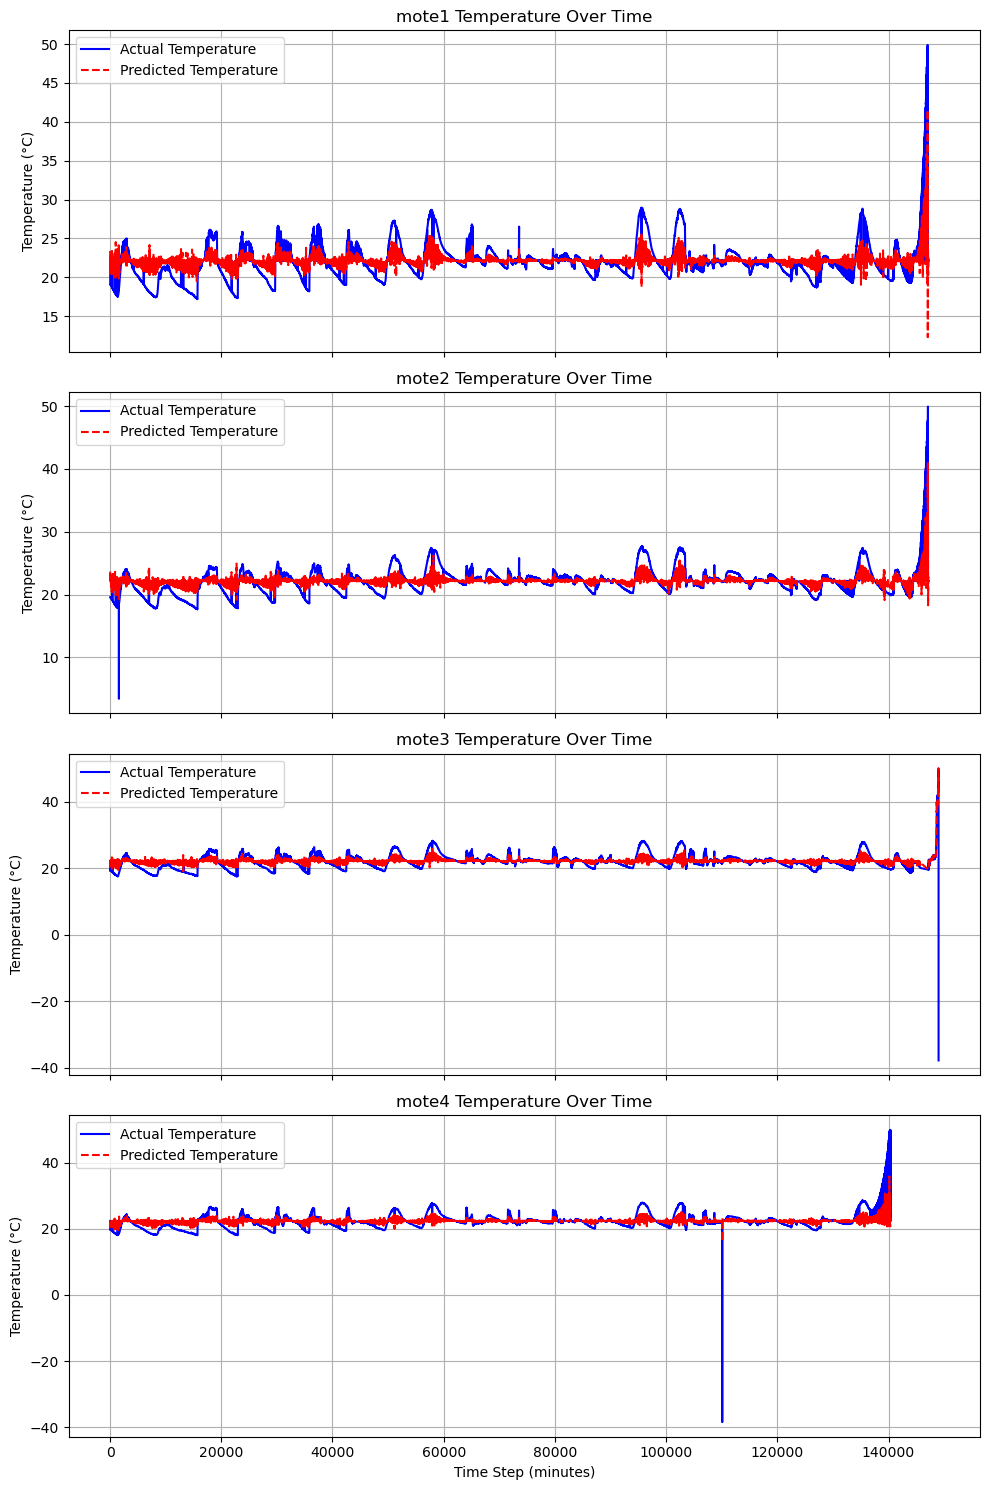

In [59]:
# Plot the actual and predicted temperatures for each mote
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

for i, mote in enumerate(['mote1', 'mote2', 'mote3', 'mote4']):
    mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
    axs[i].plot(mote_data['index'], mote_data['temperature'], 'b-', label='Actual Temperature')
    axs[i].plot(mote_data['index'], mote_data['predicted_temperature'], 'r--', label='Predicted Temperature')
    axs[i].set_title(f'{mote} Temperature Over Time')
    axs[i].set_ylabel('Temperature (°C)')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Time Step (minutes)')
plt.tight_layout()
plt.show()

In [61]:
valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
average_mse = valuable_sensor_df['squared_error'].mean()
average_mse

4.07309968422388

Average MSE: 0.4640361230117411
Average sensor lifetime (years): 0.0012501973017431454


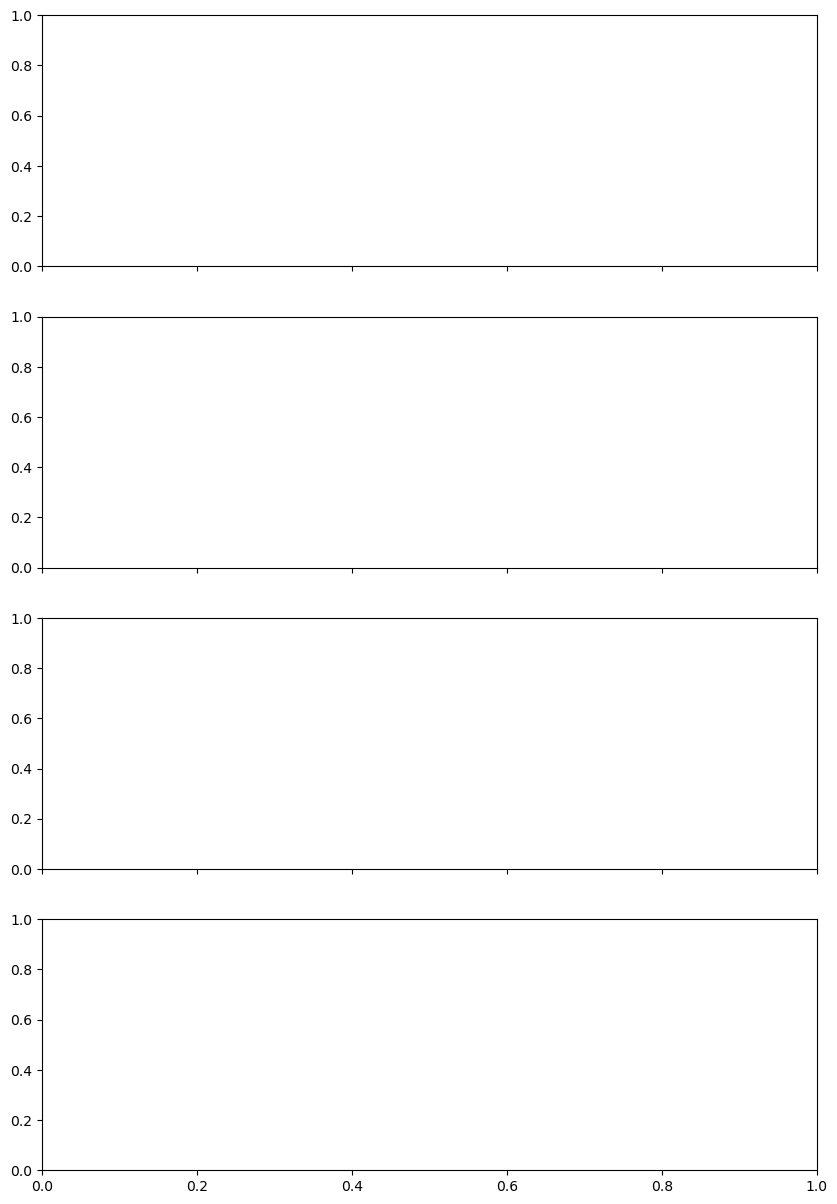

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming pivot_df is your existing DataFrame with columns: 'index', 'mote1', 'mote2', 'mote3', 'mote4'
# Here 'index' represents the minute time difference
pivot_df.set_index('index', inplace=True)

# Initialize parameters
alpha = 0.5
beta = 0.3
initial_state = 20.0  # Initial temperature estimate
initial_rate = 0.0   # Initial rate of change estimate
theta = 1.0  # Threshold for significant change
num_nodes_to_poll = 1  # Number of nodes to poll at each timestep

# Energy parameters (assumed values)
E_max = 10000  # Maximum energy capacity
E_t = 1  # Energy per transmission
E_s = 0.5  # Energy per sensing
E_w = 0.1  # Energy per waiting
E_0 = 0.05  # Energy per non-polling

# Initialize state estimates and rate of change for each mote
state_estimates = {'mote1': initial_state, 'mote2': initial_state, 'mote3': initial_state, 'mote4': initial_state}
rate_of_change = {'mote1': initial_rate, 'mote2': initial_rate, 'mote3': initial_rate, 'mote4': initial_rate}

# Initialize previous timestamps for delta time calculation
last_sensed_values = {mote: initial_state for mote in ['mote1', 'mote2', 'mote3', 'mote4']}
last_update_times = {mote: 0 for mote in ['mote1', 'mote2', 'mote3', 'mote4']}

# Initialize a list to store the most valuable sensor data and the associated metadata
valuable_sensor_data = []

# Initialize tracking arrays
polled_count = {mote: 0 for mote in ['mote1', 'mote2', 'mote3', 'mote4']}
transmitted_count = {mote: 0 for mote in ['mote1', 'mote2', 'mote3', 'mote4']}

# Function to predict node state
def predict_node_state(x_hat, x_rate, delta_t):
    return x_hat + x_rate * delta_t

# Function to select sensors based on predicted changes
def select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t):
    predicted_values = {mote: predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t) for mote in state_estimates}
    value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
    top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)[:num_nodes_to_poll]
    return top_nodes

# Simulation loop
for idx, row in pivot_df.iterrows():
    current_time_step = idx

    deviations = {}
    
    for mote in ['mote1', 'mote2', 'mote3', 'mote4']:
        current_measurement = row[mote]
        previous_state = state_estimates[mote]
        previous_rate = rate_of_change[mote]
        delta_t = current_time_step - last_update_times[mote] if last_update_times[mote] != 0 else 1  # Default to 1 if first measurement

        # Update state estimate using the provided formulas
        state_estimates[mote] = alpha * current_measurement + (1 - alpha) * (previous_state + previous_rate * delta_t)
        rate_of_change[mote] = beta * (state_estimates[mote] - previous_state) / delta_t + (1 - beta) * previous_rate
        
        # Predict future measurements
        predicted_measurement = state_estimates[mote] + rate_of_change[mote] * delta_t
        deviations[mote] = abs(predicted_measurement - current_measurement)
    
    # Predict the sensor with the most significant changes
    top_sensors = select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t)

    for mote in top_sensors:
        polled_count[mote] += 1
        measured_value = row[mote]
        predicted_value = predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t)
        
        if abs(measured_value - predicted_value) > theta:
            delta_k = current_time_step - last_update_times[mote]
            transmitted_count[mote] += 1
            state_estimates[mote] = alpha * measured_value + (1 - alpha) * (state_estimates[mote] + rate_of_change[mote] * delta_k)
            rate_of_change[mote] = beta * (state_estimates[mote] - last_sensed_values[mote]) / delta_k + (1 - beta) * rate_of_change[mote]

        last_sensed_values[mote] = state_estimates[mote]

        # Store the data
        valuable_sensor_data.append({
            'index': current_time_step,
            'selected_moteid': mote,
            'temperature': row[mote],
            'predicted_temperature': state_estimates[mote],
            'time_elapsed': current_time_step - last_update_times[mote] if last_update_times[mote] != 0 else 0
        })

    # Update the last selected index for the most valuable mote
    for mote in top_sensors:
        last_update_times[mote] = current_time_step

# Convert the list to a DataFrame
valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

# Calculate the average MSE
valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
average_mse = valuable_sensor_df['squared_error'].mean()
print(f'Average MSE: {average_mse}')

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)





# Save the DataFrame to a CSV file
#valuable_sensor_df.to_csv('valuable_sensor_df.csv', index=False)


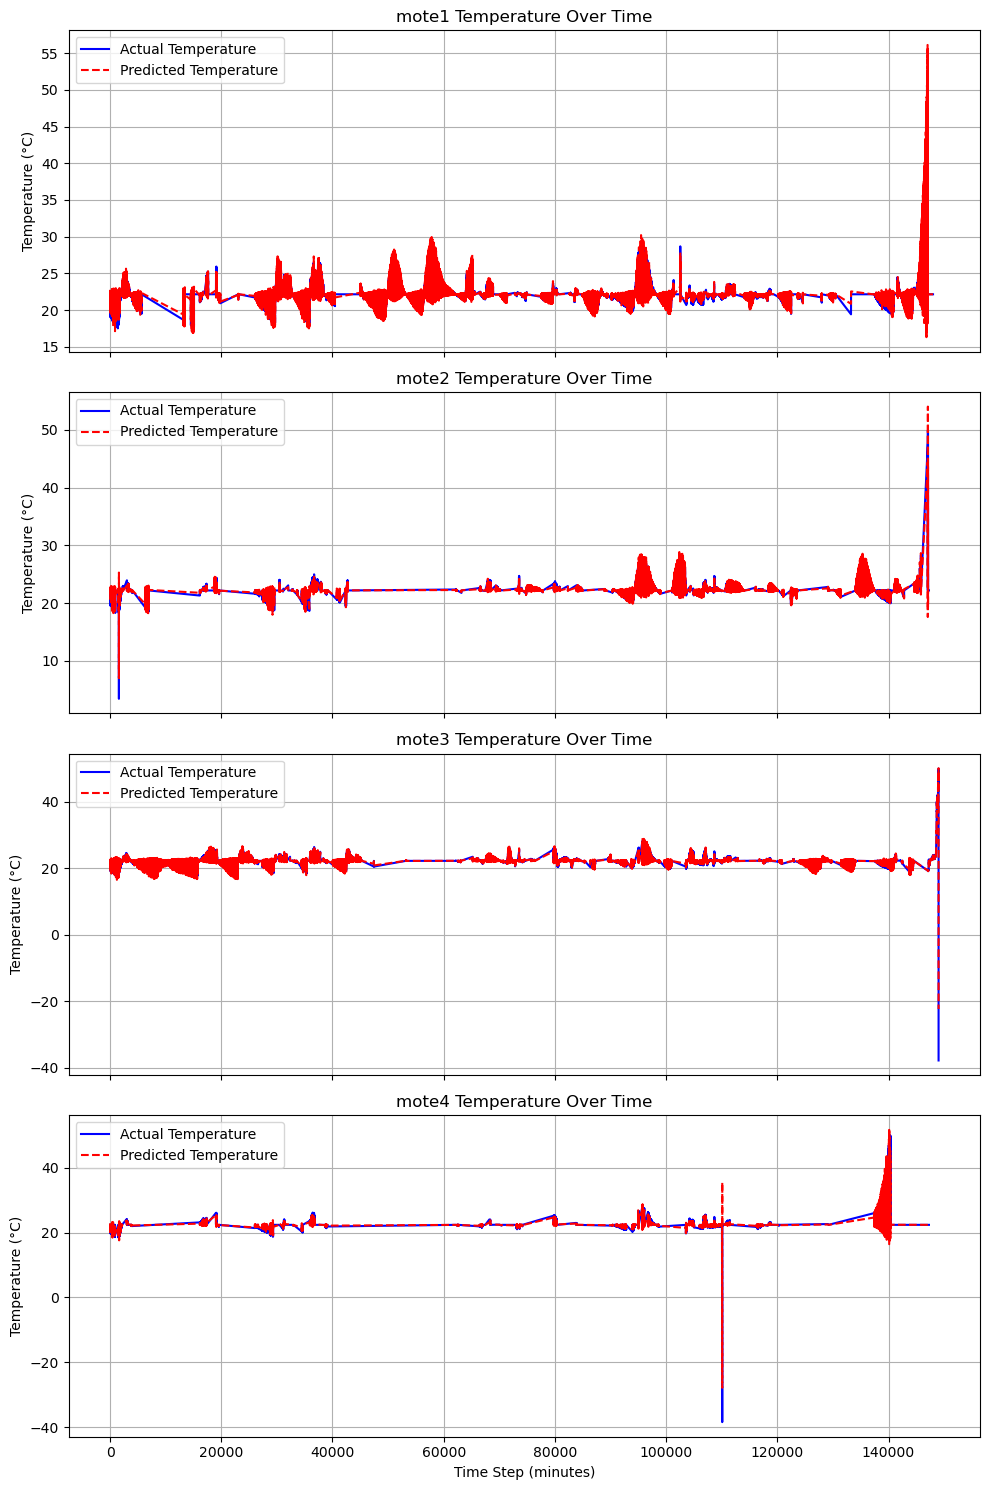

In [65]:
# Plot the actual and predicted temperatures for each mote
fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
for i, mote in enumerate(['mote1', 'mote2', 'mote3', 'mote4']):
    mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
    axs[i].plot(mote_data['index'], mote_data['temperature'], 'b-', label='Actual Temperature')
    axs[i].plot(mote_data['index'], mote_data['predicted_temperature'], 'r--', label='Predicted Temperature')
    axs[i].set_title(f'{mote} Temperature Over Time')
    axs[i].set_ylabel('Temperature (°C)')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Time Step (minutes)')
plt.tight_layout()
plt.show()